In [1]:
import pandas as pd
import numpy as np
import keras_contrib
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import LSTM, Dense, TimeDistributed, Embedding, Bidirectional
from keras.models import Model, Input
from keras_contrib.layers import CRF
from keras.callbacks import ModelCheckpoint
from keras.initializers import Constant
import csv
import codecs
import warnings
warnings.filterwarnings("ignore")
import random
random.seed(10)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import os

from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.metrics import f1_score
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from keras.preprocessing.text import text_to_word_sequence
from gensim.models.keyedvectors import KeyedVectors

Using TensorFlow backend.


In [3]:
tsvfile=open("BC5DR-disease-IOB/train.tsv",encoding="utf-8")
tsvreader = csv.reader(tsvfile, delimiter="\t")
data=[]
sentences=[]
words=[]
tags=[]
maxsentlen=0
for line in tsvreader:
    if line!=[]:
        data.append(line)
        if line[0] not in words:
            words.append(line[0])
        if line[1] not in tags:
            tags.append(line[1])
    else:
        sentences.append(data)
        if len(data)>maxsentlen:
            maxsentlen=len(data)
        data=[]

In [4]:
print(len(sentences))
print(len(words))

4560
9980


In [5]:
word_to_index = {w : i + 2 for i, w in enumerate(words)}
print(word_to_index[words[0]])
word_to_index["UNK"] = 1
word_to_index["PAD"] = 0

# Dictionary lable:index pair
# label is key and value is index.
tag_to_index = {t : i + 1 for i, t in enumerate(tags)}
print(tag_to_index[tags[0]])

tag_to_index["PAD"] = 0

idx2word = {i: w for w, i in word_to_index.items()}
print(idx2word[2])
idx2tag = {i: w for w, i in tag_to_index.items()}
print(len(tag_to_index))

2
1
Selegiline
4


In [6]:
# Number of data points passed in each iteration
batch_size =50
# Passes through entire dataset
epochs = 50
# Maximum length of review
max_len = maxsentlen+15
# Dimension of embedding vector
embedding_dim= 300

In [7]:
X = [[word_to_index[w[0]] for w in s] for s in sentences]
print(X[0],X[1])
count=0
for s in sentences:
    print(s)
    count=count+1
    if count>5:
        break
# Padding each sequence to have same length  of each word
X = pad_sequences(maxlen = max_len, sequences = X, padding = "post", value = word_to_index["PAD"])

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22] [23, 12, 24, 25, 26, 8, 9, 10, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 7, 38, 39, 8, 9, 10, 11, 30, 40, 32, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 3, 51, 52, 39, 53, 54, 50, 3, 51, 55, 22]
[['Selegiline', 'O'], ['-', 'O'], ['induced', 'O'], ['postural', 'B-Disease'], ['hypotension', 'I-Disease'], ['in', 'O'], ['Parkinson', 'B-Disease'], ["'", 'I-Disease'], ['s', 'I-Disease'], ['disease', 'I-Disease'], [':', 'O'], ['a', 'O'], ['longitudinal', 'O'], ['study', 'O'], ['on', 'O'], ['the', 'O'], ['effects', 'O'], ['of', 'O'], ['drug', 'O'], ['withdrawal', 'O'], ['.', 'O']]
[['OBJECTIVES', 'O'], [':', 'O'], ['The', 'O'], ['United', 'O'], ['Kingdom', 'O'], ['Parkinson', 'B-Disease'], ["'", 'I-Disease'], ['s', 'I-Disease'], ['Disease', 'I-Disease'], ['Research', 'O'], ['Group', 'O'], ['(', 'O'], ['UKPDRG', 'O'], [')', 'O'], ['trial', 'O'], ['found', 'O'], ['an', 'O'], ['increased', 'O'], ['mortality', 'O'], ['in',

In [8]:
print(X[0])
len(X[0])

[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0]


169

In [9]:
# Convert label to index
y = [[tag_to_index[w[1]] for w in s] for s in sentences]
print(y[0])
# padding
y = pad_sequences(maxlen = max_len, sequences = y, padding = "post", value = tag_to_index["PAD"])

[1, 1, 1, 2, 3, 1, 2, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [10]:
num_tag = 3
print(num_tag)
# One hot encoded labels
y = [to_categorical(i, num_classes = num_tag + 1) for i in y]
print(y[0][1],y[0][18])
print(len(y[0][1]))

3
[0. 1. 0. 0.] [0. 1. 0. 0.]
4


In [11]:
# Let's check the first sentence before and after processing.
print('*****Before Processing first sentence : *****\n', ' '.join([w[0] for w in sentences[0]]))
print('*****After Processing first sentence : *****\n ', X[0])
len(X[0])

*****Before Processing first sentence : *****
 Selegiline - induced postural hypotension in Parkinson ' s disease : a longitudinal study on the effects of drug withdrawal .
*****After Processing first sentence : *****
  [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0]


169

In [12]:
# First label before and after processing.
print('*****Before Processing first sentence : *****\n', ' '.join([w[1] for w in sentences[0]]))
print('*****After Processing first sentence : *****\n ', y[0])

*****Before Processing first sentence : *****
 O O O B-Disease I-Disease O B-Disease I-Disease I-Disease I-Disease O O O O O O O O O O O
*****After Processing first sentence : *****
  [[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0

In [15]:
path = "Embedding/bio_GloVe_300.txt"
f = codecs.open(path, 'r', encoding='utf-8')
embeddings_index = {}
for line in f:
    split_line = line.split()
    word = split_line[0]
    embedding1 = np.array([float(val) for val in split_line[1:]])
    embeddings_index[word] = embedding1
print('Found %s word vectors.' % len(embeddings_index))
emb=embeddings_index['gene'].tolist()
print(len(emb))
print(emb)

Found 633966 word vectors.
300
[-0.170414, 0.124066, -0.11531, -0.48346, -0.010218, 0.212453, -0.059106, -0.011211, -0.273115, -0.031161, -0.061578, -0.246429, 0.301874, -0.047402, -0.179771, -0.103855, -0.247374, 0.330996, 0.041749, 0.447276, 0.482648, 0.365678, 0.092462, 0.301248, -0.023064, -0.089027, 0.14914, 0.756354, 0.450109, -0.406125, 0.457199, 0.07989, -0.307475, 0.030622, 0.341248, 0.22113, 0.801639, 0.474214, 0.176855, -0.025022, -0.626881, 0.349852, -0.119905, 0.289109, -0.448433, 0.212642, 0.43373, -0.498386, 0.559984, -0.237298, -0.364749, 0.247834, 0.71511, -0.27462, 0.243815, 0.33679, 0.156935, 0.113424, 0.469642, 0.394421, -0.89875, 0.13933, -0.088935, 0.015076, 0.671514, -0.172198, -0.084477, 0.430311, -0.582824, -0.035599, -0.487345, -0.145008, 0.031857, 0.366613, -0.09774, -0.54506, -0.249634, -0.728636, -0.122298, 0.262496, 0.163828, 0.122999, -0.085251, -1.438981, 0.403183, -0.475071, 0.549353, 0.097049, 0.352601, -0.062208, -0.377554, -0.666492, -0.284039, 0.716

In [19]:
num_words=len(word_to_index) + 1
embedding_matrix = np.zeros((len(words)+2, embedding_dim))
for word, i in word_to_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [20]:
embedding_layer = Embedding(len(words)+2,
                            embedding_dim,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=max_len,
                            trainable=False)

In [21]:
num_tags = 3
# Model architecture
input = Input(shape = (max_len,))
#model = Embedding(input_dim = len(words) + 2, output_dim = embedding_dim, input_length = max_len, mask_zero = True)(input)
model=embedding_layer(input)
model = Bidirectional(LSTM(units = 100, return_sequences=True, recurrent_dropout=0.1))(model)
crf = CRF(num_tags+1)  # CRF layer
out = crf(model)  # output

model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 169)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 169, 300)          2994600   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 169, 200)          320800    
_________________________________________________________________
crf_2 (CRF)                  (None, 169, 4)            828       
Total params: 3,316,228
Trainable params: 321,628
Non-trainable params: 2,994,600
_________________________________________________________________


In [22]:
checkpointer = ModelCheckpoint(filepath = 'model.h5',
                       verbose = 0,
                       mode = 'auto',
                       save_best_only = True,
                       monitor='val_loss')

In [23]:
history = model.fit(X, np.array(y), batch_size=batch_size, epochs=epochs,
                    validation_split=0.1)

Instructions for updating:
Use tf.cast instead.
Train on 4104 samples, validate on 456 samples
Epoch 1/50
4104/4104 [==============================] - ETA: 15:57 - loss: 1.5186 - crf_viterbi_accuracy: 0.336 - ETA: 9:54 - loss: 1.4485 - crf_viterbi_accuracy: 0.376 - ETA: 7:07 - loss: 1.4063 - crf_viterbi_accuracy: 0.38 - ETA: 5:41 - loss: 1.3492 - crf_viterbi_accuracy: 0.40 - ETA: 4:49 - loss: 1.2602 - crf_viterbi_accuracy: 0.43 - ETA: 4:14 - loss: 1.0744 - crf_viterbi_accuracy: 0.52 - ETA: 3:48 - loss: 0.9344 - crf_viterbi_accuracy: 0.59 - ETA: 3:29 - loss: 0.8252 - crf_viterbi_accuracy: 0.64 - ETA: 3:14 - loss: 0.7414 - crf_viterbi_accuracy: 0.68 - ETA: 3:03 - loss: 0.6724 - crf_viterbi_accuracy: 0.71 - ETA: 2:53 - loss: 0.6155 - crf_viterbi_accuracy: 0.73 - ETA: 2:44 - loss: 0.5679 - crf_viterbi_accuracy: 0.75 - ETA: 2:36 - loss: 0.5284 - crf_viterbi_accuracy: 0.77 - ETA: 2:29 - loss: 0.4935 - crf_viterbi_accuracy: 0.79 - ETA: 2:23 - loss: 0.4629 - crf_viterbi_accuracy: 0.80 - ETA: 2

4104/4104 [==============================] - ETA: 1:44 - loss: 0.0232 - crf_viterbi_accuracy: 0.99 - ETA: 1:44 - loss: 0.0189 - crf_viterbi_accuracy: 0.99 - ETA: 1:44 - loss: 0.0196 - crf_viterbi_accuracy: 0.99 - ETA: 1:42 - loss: 0.0188 - crf_viterbi_accuracy: 0.99 - ETA: 1:44 - loss: 0.0178 - crf_viterbi_accuracy: 0.99 - ETA: 1:42 - loss: 0.0196 - crf_viterbi_accuracy: 0.99 - ETA: 1:41 - loss: 0.0205 - crf_viterbi_accuracy: 0.99 - ETA: 1:40 - loss: 0.0200 - crf_viterbi_accuracy: 0.99 - ETA: 1:39 - loss: 0.0193 - crf_viterbi_accuracy: 0.99 - ETA: 1:37 - loss: 0.0191 - crf_viterbi_accuracy: 0.99 - ETA: 1:35 - loss: 0.0193 - crf_viterbi_accuracy: 0.99 - ETA: 1:33 - loss: 0.0197 - crf_viterbi_accuracy: 0.99 - ETA: 1:32 - loss: 0.0195 - crf_viterbi_accuracy: 0.99 - ETA: 1:30 - loss: 0.0193 - crf_viterbi_accuracy: 0.99 - ETA: 1:29 - loss: 0.0191 - crf_viterbi_accuracy: 0.99 - ETA: 1:27 - loss: 0.0191 - crf_viterbi_accuracy: 0.99 - ETA: 1:26 - loss: 0.0190 - crf_viterbi_accuracy: 0.99 - ETA

4104/4104 [==============================] - ETA: 1:39 - loss: 0.0142 - crf_viterbi_accuracy: 0.99 - ETA: 1:42 - loss: 0.0139 - crf_viterbi_accuracy: 0.99 - ETA: 1:39 - loss: 0.0126 - crf_viterbi_accuracy: 0.99 - ETA: 1:40 - loss: 0.0138 - crf_viterbi_accuracy: 0.99 - ETA: 1:38 - loss: 0.0143 - crf_viterbi_accuracy: 0.99 - ETA: 1:36 - loss: 0.0144 - crf_viterbi_accuracy: 0.99 - ETA: 1:35 - loss: 0.0150 - crf_viterbi_accuracy: 0.99 - ETA: 1:34 - loss: 0.0152 - crf_viterbi_accuracy: 0.99 - ETA: 1:32 - loss: 0.0144 - crf_viterbi_accuracy: 0.99 - ETA: 1:31 - loss: 0.0144 - crf_viterbi_accuracy: 0.99 - ETA: 1:30 - loss: 0.0145 - crf_viterbi_accuracy: 0.99 - ETA: 1:29 - loss: 0.0152 - crf_viterbi_accuracy: 0.99 - ETA: 1:28 - loss: 0.0155 - crf_viterbi_accuracy: 0.99 - ETA: 1:27 - loss: 0.0153 - crf_viterbi_accuracy: 0.99 - ETA: 1:26 - loss: 0.0156 - crf_viterbi_accuracy: 0.99 - ETA: 1:25 - loss: 0.0155 - crf_viterbi_accuracy: 0.99 - ETA: 1:24 - loss: 0.0151 - crf_viterbi_accuracy: 0.99 - ETA

4104/4104 [==============================] - ETA: 1:48 - loss: 0.0121 - crf_viterbi_accuracy: 0.99 - ETA: 1:48 - loss: 0.0158 - crf_viterbi_accuracy: 0.99 - ETA: 1:47 - loss: 0.0136 - crf_viterbi_accuracy: 0.99 - ETA: 1:44 - loss: 0.0126 - crf_viterbi_accuracy: 0.99 - ETA: 1:43 - loss: 0.0126 - crf_viterbi_accuracy: 0.99 - ETA: 1:41 - loss: 0.0124 - crf_viterbi_accuracy: 0.99 - ETA: 1:40 - loss: 0.0119 - crf_viterbi_accuracy: 0.99 - ETA: 1:37 - loss: 0.0116 - crf_viterbi_accuracy: 0.99 - ETA: 1:36 - loss: 0.0113 - crf_viterbi_accuracy: 0.99 - ETA: 1:34 - loss: 0.0112 - crf_viterbi_accuracy: 0.99 - ETA: 1:33 - loss: 0.0110 - crf_viterbi_accuracy: 0.99 - ETA: 1:32 - loss: 0.0109 - crf_viterbi_accuracy: 0.99 - ETA: 1:31 - loss: 0.0105 - crf_viterbi_accuracy: 0.99 - ETA: 1:29 - loss: 0.0105 - crf_viterbi_accuracy: 0.99 - ETA: 1:28 - loss: 0.0106 - crf_viterbi_accuracy: 0.99 - ETA: 1:27 - loss: 0.0103 - crf_viterbi_accuracy: 0.99 - ETA: 1:25 - loss: 0.0103 - crf_viterbi_accuracy: 0.99 - ETA

4104/4104 [==============================] - ETA: 1:43 - loss: 0.0109 - crf_viterbi_accuracy: 0.99 - ETA: 1:41 - loss: 0.0099 - crf_viterbi_accuracy: 0.99 - ETA: 1:38 - loss: 0.0106 - crf_viterbi_accuracy: 0.99 - ETA: 1:37 - loss: 0.0111 - crf_viterbi_accuracy: 0.99 - ETA: 1:35 - loss: 0.0107 - crf_viterbi_accuracy: 0.99 - ETA: 1:33 - loss: 0.0105 - crf_viterbi_accuracy: 0.99 - ETA: 1:32 - loss: 0.0102 - crf_viterbi_accuracy: 0.99 - ETA: 1:31 - loss: 0.0099 - crf_viterbi_accuracy: 0.99 - ETA: 1:31 - loss: 0.0094 - crf_viterbi_accuracy: 0.99 - ETA: 1:31 - loss: 0.0093 - crf_viterbi_accuracy: 0.99 - ETA: 1:30 - loss: 0.0091 - crf_viterbi_accuracy: 0.99 - ETA: 1:29 - loss: 0.0090 - crf_viterbi_accuracy: 0.99 - ETA: 1:29 - loss: 0.0089 - crf_viterbi_accuracy: 0.99 - ETA: 1:28 - loss: 0.0087 - crf_viterbi_accuracy: 0.99 - ETA: 1:28 - loss: 0.0086 - crf_viterbi_accuracy: 0.99 - ETA: 1:26 - loss: 0.0085 - crf_viterbi_accuracy: 0.99 - ETA: 1:25 - loss: 0.0088 - crf_viterbi_accuracy: 0.99 - ETA

4104/4104 [==============================] - ETA: 1:42 - loss: 0.0099 - crf_viterbi_accuracy: 0.99 - ETA: 1:44 - loss: 0.0089 - crf_viterbi_accuracy: 0.99 - ETA: 1:44 - loss: 0.0084 - crf_viterbi_accuracy: 0.99 - ETA: 1:45 - loss: 0.0083 - crf_viterbi_accuracy: 0.99 - ETA: 1:42 - loss: 0.0079 - crf_viterbi_accuracy: 0.99 - ETA: 1:40 - loss: 0.0070 - crf_viterbi_accuracy: 0.99 - ETA: 1:38 - loss: 0.0066 - crf_viterbi_accuracy: 0.99 - ETA: 1:37 - loss: 0.0070 - crf_viterbi_accuracy: 0.99 - ETA: 1:35 - loss: 0.0072 - crf_viterbi_accuracy: 0.99 - ETA: 1:34 - loss: 0.0072 - crf_viterbi_accuracy: 0.99 - ETA: 1:33 - loss: 0.0073 - crf_viterbi_accuracy: 0.99 - ETA: 1:32 - loss: 0.0070 - crf_viterbi_accuracy: 0.99 - ETA: 1:30 - loss: 0.0072 - crf_viterbi_accuracy: 0.99 - ETA: 1:29 - loss: 0.0073 - crf_viterbi_accuracy: 0.99 - ETA: 1:27 - loss: 0.0070 - crf_viterbi_accuracy: 0.99 - ETA: 1:26 - loss: 0.0067 - crf_viterbi_accuracy: 0.99 - ETA: 1:24 - loss: 0.0068 - crf_viterbi_accuracy: 0.99 - ETA

4104/4104 [==============================] - ETA: 1:43 - loss: 0.0034 - crf_viterbi_accuracy: 0.99 - ETA: 1:43 - loss: 0.0049 - crf_viterbi_accuracy: 0.99 - ETA: 1:42 - loss: 0.0051 - crf_viterbi_accuracy: 0.99 - ETA: 1:40 - loss: 0.0051 - crf_viterbi_accuracy: 0.99 - ETA: 1:39 - loss: 0.0049 - crf_viterbi_accuracy: 0.99 - ETA: 1:39 - loss: 0.0049 - crf_viterbi_accuracy: 0.99 - ETA: 1:39 - loss: 0.0049 - crf_viterbi_accuracy: 0.99 - ETA: 1:38 - loss: 0.0047 - crf_viterbi_accuracy: 0.99 - ETA: 1:37 - loss: 0.0047 - crf_viterbi_accuracy: 0.99 - ETA: 1:36 - loss: 0.0049 - crf_viterbi_accuracy: 0.99 - ETA: 1:34 - loss: 0.0049 - crf_viterbi_accuracy: 0.99 - ETA: 1:33 - loss: 0.0048 - crf_viterbi_accuracy: 0.99 - ETA: 1:31 - loss: 0.0050 - crf_viterbi_accuracy: 0.99 - ETA: 1:30 - loss: 0.0049 - crf_viterbi_accuracy: 0.99 - ETA: 1:28 - loss: 0.0048 - crf_viterbi_accuracy: 0.99 - ETA: 1:27 - loss: 0.0050 - crf_viterbi_accuracy: 0.99 - ETA: 1:25 - loss: 0.0051 - crf_viterbi_accuracy: 0.99 - ETA

4104/4104 [==============================] - ETA: 1:38 - loss: 0.0038 - crf_viterbi_accuracy: 0.99 - ETA: 1:39 - loss: 0.0029 - crf_viterbi_accuracy: 0.99 - ETA: 1:39 - loss: 0.0028 - crf_viterbi_accuracy: 0.99 - ETA: 1:37 - loss: 0.0032 - crf_viterbi_accuracy: 0.99 - ETA: 1:37 - loss: 0.0033 - crf_viterbi_accuracy: 0.99 - ETA: 1:37 - loss: 0.0032 - crf_viterbi_accuracy: 0.99 - ETA: 1:35 - loss: 0.0029 - crf_viterbi_accuracy: 0.99 - ETA: 1:34 - loss: 0.0032 - crf_viterbi_accuracy: 0.99 - ETA: 1:32 - loss: 0.0031 - crf_viterbi_accuracy: 0.99 - ETA: 1:30 - loss: 0.0028 - crf_viterbi_accuracy: 0.99 - ETA: 1:28 - loss: 0.0038 - crf_viterbi_accuracy: 0.99 - ETA: 1:27 - loss: 0.0038 - crf_viterbi_accuracy: 0.99 - ETA: 1:26 - loss: 0.0038 - crf_viterbi_accuracy: 0.99 - ETA: 1:24 - loss: 0.0037 - crf_viterbi_accuracy: 0.99 - ETA: 1:23 - loss: 0.0037 - crf_viterbi_accuracy: 0.99 - ETA: 1:22 - loss: 0.0038 - crf_viterbi_accuracy: 0.99 - ETA: 1:22 - loss: 0.0038 - crf_viterbi_accuracy: 0.99 - ETA

4104/4104 [==============================] - ETA: 1:47 - loss: 0.0021 - crf_viterbi_accuracy: 0.99 - ETA: 1:49 - loss: 0.0014 - crf_viterbi_accuracy: 0.99 - ETA: 1:48 - loss: 0.0015 - crf_viterbi_accuracy: 0.99 - ETA: 1:46 - loss: 0.0012 - crf_viterbi_accuracy: 0.99 - ETA: 1:44 - loss: 0.0013 - crf_viterbi_accuracy: 0.99 - ETA: 1:42 - loss: 0.0011 - crf_viterbi_accuracy: 0.99 - ETA: 1:39 - loss: 0.0012 - crf_viterbi_accuracy: 0.99 - ETA: 1:37 - loss: 0.0011 - crf_viterbi_accuracy: 0.99 - ETA: 1:36 - loss: 0.0010 - crf_viterbi_accuracy: 0.99 - ETA: 1:33 - loss: 0.0012 - crf_viterbi_accuracy: 0.99 - ETA: 1:32 - loss: 0.0018 - crf_viterbi_accuracy: 0.99 - ETA: 1:30 - loss: 0.0020 - crf_viterbi_accuracy: 0.99 - ETA: 1:29 - loss: 0.0020 - crf_viterbi_accuracy: 0.99 - ETA: 1:27 - loss: 0.0019 - crf_viterbi_accuracy: 0.99 - ETA: 1:26 - loss: 0.0021 - crf_viterbi_accuracy: 0.99 - ETA: 1:24 - loss: 0.0020 - crf_viterbi_accuracy: 0.99 - ETA: 1:23 - loss: 0.0021 - crf_viterbi_accuracy: 0.99 - ETA

4104/4104 [==============================] - ETA: 1:38 - loss: 0.0033 - crf_viterbi_accuracy: 0.99 - ETA: 1:37 - loss: 0.0019 - crf_viterbi_accuracy: 0.99 - ETA: 1:36 - loss: 0.0016 - crf_viterbi_accuracy: 0.99 - ETA: 1:36 - loss: 0.0015 - crf_viterbi_accuracy: 0.99 - ETA: 1:36 - loss: 0.0013 - crf_viterbi_accuracy: 0.99 - ETA: 1:34 - loss: 0.0010 - crf_viterbi_accuracy: 0.99 - ETA: 1:32 - loss: 8.5335e-04 - crf_viterbi_accuracy: 0.99 - ETA: 1:32 - loss: 0.0015 - crf_viterbi_accuracy: 0.9983   - ETA: 1:30 - loss: 0.0017 - crf_viterbi_accuracy: 0.99 - ETA: 1:29 - loss: 0.0018 - crf_viterbi_accuracy: 0.99 - ETA: 1:29 - loss: 0.0017 - crf_viterbi_accuracy: 0.99 - ETA: 1:28 - loss: 0.0016 - crf_viterbi_accuracy: 0.99 - ETA: 1:27 - loss: 0.0017 - crf_viterbi_accuracy: 0.99 - ETA: 1:27 - loss: 0.0016 - crf_viterbi_accuracy: 0.99 - ETA: 1:26 - loss: 0.0016 - crf_viterbi_accuracy: 0.99 - ETA: 1:25 - loss: 0.0016 - crf_viterbi_accuracy: 0.99 - ETA: 1:23 - loss: 0.0015 - crf_viterbi_accuracy: 0.

4104/4104 [==============================] - ETA: 1:36 - loss: -1.9930e-04 - crf_viterbi_accuracy: 0.998 - ETA: 1:38 - loss: -4.1846e-04 - crf_viterbi_accuracy: 0.998 - ETA: 1:36 - loss: -5.8641e-04 - crf_viterbi_accuracy: 0.998 - ETA: 1:37 - loss: -4.1933e-04 - crf_viterbi_accuracy: 0.998 - ETA: 1:36 - loss: -5.0307e-04 - crf_viterbi_accuracy: 0.998 - ETA: 1:35 - loss: -5.7302e-04 - crf_viterbi_accuracy: 0.998 - ETA: 1:34 - loss: -6.8495e-04 - crf_viterbi_accuracy: 0.998 - ETA: 1:33 - loss: -7.2641e-04 - crf_viterbi_accuracy: 0.998 - ETA: 1:32 - loss: -7.3900e-04 - crf_viterbi_accuracy: 0.998 - ETA: 1:31 - loss: -7.3059e-04 - crf_viterbi_accuracy: 0.998 - ETA: 1:30 - loss: -6.1524e-04 - crf_viterbi_accuracy: 0.998 - ETA: 1:30 - loss: -6.8102e-04 - crf_viterbi_accuracy: 0.998 - ETA: 1:28 - loss: -7.6878e-04 - crf_viterbi_accuracy: 0.998 - ETA: 1:27 - loss: -7.3511e-04 - crf_viterbi_accuracy: 0.998 - ETA: 1:26 - loss: -6.6978e-04 - crf_viterbi_accuracy: 0.998 - ETA: 1:24 - loss: -5.3249

4104/4104 [==============================] - ETA: 1:43 - loss: -0.0024 - crf_viterbi_accuracy: 0.998 - ETA: 1:40 - loss: -0.0016 - crf_viterbi_accuracy: 0.998 - ETA: 1:40 - loss: -0.0018 - crf_viterbi_accuracy: 0.999 - ETA: 1:41 - loss: -0.0014 - crf_viterbi_accuracy: 0.998 - ETA: 1:41 - loss: -0.0013 - crf_viterbi_accuracy: 0.998 - ETA: 1:39 - loss: -0.0014 - crf_viterbi_accuracy: 0.998 - ETA: 1:39 - loss: -0.0015 - crf_viterbi_accuracy: 0.998 - ETA: 1:38 - loss: -0.0013 - crf_viterbi_accuracy: 0.998 - ETA: 1:36 - loss: -0.0012 - crf_viterbi_accuracy: 0.998 - ETA: 1:36 - loss: -0.0013 - crf_viterbi_accuracy: 0.998 - ETA: 1:35 - loss: -0.0013 - crf_viterbi_accuracy: 0.998 - ETA: 1:34 - loss: -0.0013 - crf_viterbi_accuracy: 0.998 - ETA: 1:32 - loss: -0.0014 - crf_viterbi_accuracy: 0.998 - ETA: 1:30 - loss: -0.0013 - crf_viterbi_accuracy: 0.998 - ETA: 1:29 - loss: -0.0015 - crf_viterbi_accuracy: 0.998 - ETA: 1:28 - loss: -0.0012 - crf_viterbi_accuracy: 0.998 - ETA: 1:26 - loss: -0.0011 -

4104/4104 [==============================] - ETA: 1:05 - loss: -0.0027 - crf_viterbi_accuracy: 0.999 - ETA: 1:04 - loss: -0.0021 - crf_viterbi_accuracy: 0.999 - ETA: 1:03 - loss: -0.0023 - crf_viterbi_accuracy: 0.999 - ETA: 1:03 - loss: -0.0017 - crf_viterbi_accuracy: 0.998 - ETA: 1:02 - loss: -0.0019 - crf_viterbi_accuracy: 0.999 - ETA: 1:00 - loss: -0.0020 - crf_viterbi_accuracy: 0.999 - ETA: 59s - loss: -0.0021 - crf_viterbi_accuracy: 0.999 - ETA: 58s - loss: -0.0022 - crf_viterbi_accuracy: 0.99 - ETA: 58s - loss: -0.0021 - crf_viterbi_accuracy: 0.99 - ETA: 57s - loss: -0.0022 - crf_viterbi_accuracy: 0.99 - ETA: 57s - loss: -0.0023 - crf_viterbi_accuracy: 0.99 - ETA: 56s - loss: -0.0024 - crf_viterbi_accuracy: 0.99 - ETA: 55s - loss: -0.0024 - crf_viterbi_accuracy: 0.99 - ETA: 54s - loss: -0.0024 - crf_viterbi_accuracy: 0.99 - ETA: 54s - loss: -0.0025 - crf_viterbi_accuracy: 0.99 - ETA: 53s - loss: -0.0023 - crf_viterbi_accuracy: 0.99 - ETA: 52s - loss: -0.0022 - crf_viterbi_accurac

4104/4104 [==============================] - ETA: 1:07 - loss: -0.0030 - crf_viterbi_accuracy: 0.999 - ETA: 1:03 - loss: -0.0031 - crf_viterbi_accuracy: 0.998 - ETA: 1:04 - loss: -0.0034 - crf_viterbi_accuracy: 0.999 - ETA: 1:03 - loss: -0.0033 - crf_viterbi_accuracy: 0.999 - ETA: 1:03 - loss: -0.0036 - crf_viterbi_accuracy: 0.999 - ETA: 1:02 - loss: -0.0035 - crf_viterbi_accuracy: 0.999 - ETA: 1:01 - loss: -0.0036 - crf_viterbi_accuracy: 0.999 - ETA: 1:00 - loss: -0.0036 - crf_viterbi_accuracy: 0.999 - ETA: 59s - loss: -0.0034 - crf_viterbi_accuracy: 0.999 - ETA: 58s - loss: -0.0034 - crf_viterbi_accuracy: 0.99 - ETA: 57s - loss: -0.0032 - crf_viterbi_accuracy: 0.99 - ETA: 57s - loss: -0.0031 - crf_viterbi_accuracy: 0.99 - ETA: 56s - loss: -0.0031 - crf_viterbi_accuracy: 0.99 - ETA: 55s - loss: -0.0031 - crf_viterbi_accuracy: 0.99 - ETA: 55s - loss: -0.0031 - crf_viterbi_accuracy: 0.99 - ETA: 54s - loss: -0.0032 - crf_viterbi_accuracy: 0.99 - ETA: 53s - loss: -0.0032 - crf_viterbi_acc

4104/4104 [==============================] - ETA: 1:00 - loss: -0.0026 - crf_viterbi_accuracy: 0.999 - ETA: 58s - loss: -0.0033 - crf_viterbi_accuracy: 0.999 - ETA: 57s - loss: -0.0035 - crf_viterbi_accuracy: 0.99 - ETA: 56s - loss: -0.0037 - crf_viterbi_accuracy: 0.99 - ETA: 55s - loss: -0.0039 - crf_viterbi_accuracy: 0.99 - ETA: 54s - loss: -0.0040 - crf_viterbi_accuracy: 0.99 - ETA: 53s - loss: -0.0041 - crf_viterbi_accuracy: 0.99 - ETA: 53s - loss: -0.0041 - crf_viterbi_accuracy: 0.99 - ETA: 52s - loss: -0.0041 - crf_viterbi_accuracy: 0.99 - ETA: 51s - loss: -0.0041 - crf_viterbi_accuracy: 0.99 - ETA: 50s - loss: -0.0042 - crf_viterbi_accuracy: 0.99 - ETA: 50s - loss: -0.0042 - crf_viterbi_accuracy: 0.99 - ETA: 49s - loss: -0.0043 - crf_viterbi_accuracy: 0.99 - ETA: 49s - loss: -0.0042 - crf_viterbi_accuracy: 0.99 - ETA: 48s - loss: -0.0041 - crf_viterbi_accuracy: 0.99 - ETA: 48s - loss: -0.0041 - crf_viterbi_accuracy: 0.99 - ETA: 47s - loss: -0.0041 - crf_viterbi_accuracy: 0.99 - 

4104/4104 [==============================] - ETA: 1:03 - loss: -0.0050 - crf_viterbi_accuracy: 0.999 - ETA: 1:00 - loss: -0.0050 - crf_viterbi_accuracy: 0.999 - ETA: 1:00 - loss: -0.0051 - crf_viterbi_accuracy: 0.999 - ETA: 58s - loss: -0.0052 - crf_viterbi_accuracy: 0.999 - ETA: 57s - loss: -0.0052 - crf_viterbi_accuracy: 0.99 - ETA: 56s - loss: -0.0052 - crf_viterbi_accuracy: 0.99 - ETA: 55s - loss: -0.0053 - crf_viterbi_accuracy: 0.99 - ETA: 55s - loss: -0.0052 - crf_viterbi_accuracy: 0.99 - ETA: 54s - loss: -0.0052 - crf_viterbi_accuracy: 0.99 - ETA: 53s - loss: -0.0052 - crf_viterbi_accuracy: 0.99 - ETA: 52s - loss: -0.0051 - crf_viterbi_accuracy: 0.99 - ETA: 51s - loss: -0.0051 - crf_viterbi_accuracy: 0.99 - ETA: 50s - loss: -0.0052 - crf_viterbi_accuracy: 0.99 - ETA: 50s - loss: -0.0052 - crf_viterbi_accuracy: 0.99 - ETA: 49s - loss: -0.0052 - crf_viterbi_accuracy: 0.99 - ETA: 48s - loss: -0.0052 - crf_viterbi_accuracy: 0.99 - ETA: 47s - loss: -0.0053 - crf_viterbi_accuracy: 0.9

4104/4104 [==============================] - ETA: 1:01 - loss: -0.0051 - crf_viterbi_accuracy: 0.999 - ETA: 1:01 - loss: -0.0052 - crf_viterbi_accuracy: 0.999 - ETA: 59s - loss: -0.0053 - crf_viterbi_accuracy: 0.999 - ETA: 57s - loss: -0.0056 - crf_viterbi_accuracy: 0.99 - ETA: 55s - loss: -0.0057 - crf_viterbi_accuracy: 0.99 - ETA: 54s - loss: -0.0058 - crf_viterbi_accuracy: 0.99 - ETA: 54s - loss: -0.0058 - crf_viterbi_accuracy: 0.99 - ETA: 54s - loss: -0.0057 - crf_viterbi_accuracy: 0.99 - ETA: 53s - loss: -0.0057 - crf_viterbi_accuracy: 0.99 - ETA: 53s - loss: -0.0057 - crf_viterbi_accuracy: 0.99 - ETA: 52s - loss: -0.0057 - crf_viterbi_accuracy: 0.99 - ETA: 52s - loss: -0.0058 - crf_viterbi_accuracy: 0.99 - ETA: 51s - loss: -0.0057 - crf_viterbi_accuracy: 0.99 - ETA: 51s - loss: -0.0057 - crf_viterbi_accuracy: 0.99 - ETA: 50s - loss: -0.0058 - crf_viterbi_accuracy: 0.99 - ETA: 49s - loss: -0.0058 - crf_viterbi_accuracy: 0.99 - ETA: 49s - loss: -0.0058 - crf_viterbi_accuracy: 0.99 

4104/4104 [==============================] - ETA: 59s - loss: -0.0069 - crf_viterbi_accuracy: 0.99 - ETA: 57s - loss: -0.0068 - crf_viterbi_accuracy: 0.99 - ETA: 56s - loss: -0.0068 - crf_viterbi_accuracy: 0.99 - ETA: 55s - loss: -0.0068 - crf_viterbi_accuracy: 0.99 - ETA: 55s - loss: -0.0068 - crf_viterbi_accuracy: 0.99 - ETA: 54s - loss: -0.0068 - crf_viterbi_accuracy: 0.99 - ETA: 53s - loss: -0.0068 - crf_viterbi_accuracy: 0.99 - ETA: 52s - loss: -0.0068 - crf_viterbi_accuracy: 0.99 - ETA: 52s - loss: -0.0068 - crf_viterbi_accuracy: 0.99 - ETA: 51s - loss: -0.0067 - crf_viterbi_accuracy: 0.99 - ETA: 50s - loss: -0.0067 - crf_viterbi_accuracy: 0.99 - ETA: 50s - loss: -0.0067 - crf_viterbi_accuracy: 0.99 - ETA: 49s - loss: -0.0067 - crf_viterbi_accuracy: 0.99 - ETA: 48s - loss: -0.0067 - crf_viterbi_accuracy: 0.99 - ETA: 47s - loss: -0.0067 - crf_viterbi_accuracy: 0.99 - ETA: 47s - loss: -0.0067 - crf_viterbi_accuracy: 0.99 - ETA: 46s - loss: -0.0067 - crf_viterbi_accuracy: 0.99 - ETA

4104/4104 [==============================] - ETA: 1:00 - loss: -0.0067 - crf_viterbi_accuracy: 0.999 - ETA: 57s - loss: -0.0070 - crf_viterbi_accuracy: 0.999 - ETA: 56s - loss: -0.0072 - crf_viterbi_accuracy: 0.99 - ETA: 56s - loss: -0.0071 - crf_viterbi_accuracy: 0.99 - ETA: 56s - loss: -0.0072 - crf_viterbi_accuracy: 0.99 - ETA: 55s - loss: -0.0073 - crf_viterbi_accuracy: 0.99 - ETA: 55s - loss: -0.0073 - crf_viterbi_accuracy: 0.99 - ETA: 54s - loss: -0.0073 - crf_viterbi_accuracy: 0.99 - ETA: 53s - loss: -0.0073 - crf_viterbi_accuracy: 0.99 - ETA: 52s - loss: -0.0072 - crf_viterbi_accuracy: 0.99 - ETA: 51s - loss: -0.0072 - crf_viterbi_accuracy: 0.99 - ETA: 50s - loss: -0.0073 - crf_viterbi_accuracy: 0.99 - ETA: 49s - loss: -0.0072 - crf_viterbi_accuracy: 0.99 - ETA: 49s - loss: -0.0072 - crf_viterbi_accuracy: 0.99 - ETA: 48s - loss: -0.0072 - crf_viterbi_accuracy: 0.99 - ETA: 47s - loss: -0.0071 - crf_viterbi_accuracy: 0.99 - ETA: 46s - loss: -0.0071 - crf_viterbi_accuracy: 0.99 - 

4104/4104 [==============================] - ETA: 58s - loss: -0.0079 - crf_viterbi_accuracy: 0.99 - ETA: 56s - loss: -0.0076 - crf_viterbi_accuracy: 0.99 - ETA: 56s - loss: -0.0077 - crf_viterbi_accuracy: 0.99 - ETA: 55s - loss: -0.0076 - crf_viterbi_accuracy: 0.99 - ETA: 54s - loss: -0.0077 - crf_viterbi_accuracy: 0.99 - ETA: 53s - loss: -0.0078 - crf_viterbi_accuracy: 0.99 - ETA: 52s - loss: -0.0077 - crf_viterbi_accuracy: 0.99 - ETA: 52s - loss: -0.0077 - crf_viterbi_accuracy: 0.99 - ETA: 51s - loss: -0.0078 - crf_viterbi_accuracy: 0.99 - ETA: 51s - loss: -0.0077 - crf_viterbi_accuracy: 0.99 - ETA: 50s - loss: -0.0076 - crf_viterbi_accuracy: 0.99 - ETA: 49s - loss: -0.0075 - crf_viterbi_accuracy: 0.99 - ETA: 49s - loss: -0.0075 - crf_viterbi_accuracy: 0.99 - ETA: 48s - loss: -0.0076 - crf_viterbi_accuracy: 0.99 - ETA: 48s - loss: -0.0076 - crf_viterbi_accuracy: 0.99 - ETA: 47s - loss: -0.0076 - crf_viterbi_accuracy: 0.99 - ETA: 47s - loss: -0.0077 - crf_viterbi_accuracy: 0.99 - ETA

4104/4104 [==============================] - ETA: 1:00 - loss: -0.0087 - crf_viterbi_accuracy: 1.000 - ETA: 58s - loss: -0.0084 - crf_viterbi_accuracy: 0.999 - ETA: 58s - loss: -0.0080 - crf_viterbi_accuracy: 0.99 - ETA: 56s - loss: -0.0082 - crf_viterbi_accuracy: 0.99 - ETA: 55s - loss: -0.0083 - crf_viterbi_accuracy: 0.99 - ETA: 53s - loss: -0.0081 - crf_viterbi_accuracy: 0.99 - ETA: 54s - loss: -0.0081 - crf_viterbi_accuracy: 0.99 - ETA: 53s - loss: -0.0082 - crf_viterbi_accuracy: 0.99 - ETA: 52s - loss: -0.0082 - crf_viterbi_accuracy: 0.99 - ETA: 52s - loss: -0.0082 - crf_viterbi_accuracy: 0.99 - ETA: 51s - loss: -0.0083 - crf_viterbi_accuracy: 0.99 - ETA: 50s - loss: -0.0083 - crf_viterbi_accuracy: 0.99 - ETA: 50s - loss: -0.0083 - crf_viterbi_accuracy: 0.99 - ETA: 49s - loss: -0.0083 - crf_viterbi_accuracy: 0.99 - ETA: 48s - loss: -0.0083 - crf_viterbi_accuracy: 0.99 - ETA: 47s - loss: -0.0083 - crf_viterbi_accuracy: 0.99 - ETA: 46s - loss: -0.0083 - crf_viterbi_accuracy: 0.99 - 

4104/4104 [==============================] - ETA: 59s - loss: -0.0091 - crf_viterbi_accuracy: 0.99 - ETA: 57s - loss: -0.0091 - crf_viterbi_accuracy: 0.99 - ETA: 56s - loss: -0.0091 - crf_viterbi_accuracy: 0.99 - ETA: 55s - loss: -0.0091 - crf_viterbi_accuracy: 0.99 - ETA: 54s - loss: -0.0091 - crf_viterbi_accuracy: 0.99 - ETA: 53s - loss: -0.0091 - crf_viterbi_accuracy: 0.99 - ETA: 52s - loss: -0.0092 - crf_viterbi_accuracy: 0.99 - ETA: 52s - loss: -0.0092 - crf_viterbi_accuracy: 0.99 - ETA: 52s - loss: -0.0092 - crf_viterbi_accuracy: 0.99 - ETA: 52s - loss: -0.0092 - crf_viterbi_accuracy: 0.99 - ETA: 51s - loss: -0.0092 - crf_viterbi_accuracy: 0.99 - ETA: 51s - loss: -0.0092 - crf_viterbi_accuracy: 0.99 - ETA: 50s - loss: -0.0092 - crf_viterbi_accuracy: 0.99 - ETA: 49s - loss: -0.0091 - crf_viterbi_accuracy: 0.99 - ETA: 48s - loss: -0.0091 - crf_viterbi_accuracy: 0.99 - ETA: 48s - loss: -0.0091 - crf_viterbi_accuracy: 0.99 - ETA: 47s - loss: -0.0091 - crf_viterbi_accuracy: 0.99 - ETA

4104/4104 [==============================] - ETA: 58s - loss: -0.0096 - crf_viterbi_accuracy: 1.00 - ETA: 55s - loss: -0.0097 - crf_viterbi_accuracy: 1.00 - ETA: 55s - loss: -0.0097 - crf_viterbi_accuracy: 1.00 - ETA: 54s - loss: -0.0097 - crf_viterbi_accuracy: 1.00 - ETA: 53s - loss: -0.0097 - crf_viterbi_accuracy: 1.00 - ETA: 53s - loss: -0.0097 - crf_viterbi_accuracy: 1.00 - ETA: 52s - loss: -0.0098 - crf_viterbi_accuracy: 1.00 - ETA: 51s - loss: -0.0097 - crf_viterbi_accuracy: 0.99 - ETA: 51s - loss: -0.0097 - crf_viterbi_accuracy: 0.99 - ETA: 50s - loss: -0.0096 - crf_viterbi_accuracy: 0.99 - ETA: 49s - loss: -0.0096 - crf_viterbi_accuracy: 0.99 - ETA: 49s - loss: -0.0096 - crf_viterbi_accuracy: 0.99 - ETA: 48s - loss: -0.0096 - crf_viterbi_accuracy: 0.99 - ETA: 47s - loss: -0.0096 - crf_viterbi_accuracy: 0.99 - ETA: 47s - loss: -0.0096 - crf_viterbi_accuracy: 0.99 - ETA: 46s - loss: -0.0096 - crf_viterbi_accuracy: 0.99 - ETA: 46s - loss: -0.0096 - crf_viterbi_accuracy: 0.99 - ETA

4104/4104 [==============================] - ETA: 59s - loss: -0.0102 - crf_viterbi_accuracy: 1.00 - ETA: 56s - loss: -0.0102 - crf_viterbi_accuracy: 0.99 - ETA: 56s - loss: -0.0099 - crf_viterbi_accuracy: 0.99 - ETA: 57s - loss: -0.0099 - crf_viterbi_accuracy: 0.99 - ETA: 56s - loss: -0.0099 - crf_viterbi_accuracy: 0.99 - ETA: 55s - loss: -0.0100 - crf_viterbi_accuracy: 0.99 - ETA: 55s - loss: -0.0101 - crf_viterbi_accuracy: 0.99 - ETA: 54s - loss: -0.0101 - crf_viterbi_accuracy: 0.99 - ETA: 53s - loss: -0.0101 - crf_viterbi_accuracy: 0.99 - ETA: 52s - loss: -0.0101 - crf_viterbi_accuracy: 0.99 - ETA: 51s - loss: -0.0101 - crf_viterbi_accuracy: 0.99 - ETA: 50s - loss: -0.0102 - crf_viterbi_accuracy: 0.99 - ETA: 49s - loss: -0.0101 - crf_viterbi_accuracy: 0.99 - ETA: 48s - loss: -0.0101 - crf_viterbi_accuracy: 0.99 - ETA: 47s - loss: -0.0101 - crf_viterbi_accuracy: 0.99 - ETA: 47s - loss: -0.0101 - crf_viterbi_accuracy: 0.99 - ETA: 46s - loss: -0.0102 - crf_viterbi_accuracy: 0.99 - ETA

4104/4104 [==============================] - ETA: 59s - loss: -0.0106 - crf_viterbi_accuracy: 1.00 - ETA: 56s - loss: -0.0104 - crf_viterbi_accuracy: 0.99 - ETA: 56s - loss: -0.0105 - crf_viterbi_accuracy: 1.00 - ETA: 55s - loss: -0.0106 - crf_viterbi_accuracy: 1.00 - ETA: 55s - loss: -0.0107 - crf_viterbi_accuracy: 1.00 - ETA: 54s - loss: -0.0107 - crf_viterbi_accuracy: 1.00 - ETA: 53s - loss: -0.0107 - crf_viterbi_accuracy: 1.00 - ETA: 53s - loss: -0.0108 - crf_viterbi_accuracy: 1.00 - ETA: 52s - loss: -0.0108 - crf_viterbi_accuracy: 1.00 - ETA: 51s - loss: -0.0108 - crf_viterbi_accuracy: 1.00 - ETA: 50s - loss: -0.0108 - crf_viterbi_accuracy: 1.00 - ETA: 50s - loss: -0.0108 - crf_viterbi_accuracy: 1.00 - ETA: 49s - loss: -0.0108 - crf_viterbi_accuracy: 1.00 - ETA: 49s - loss: -0.0108 - crf_viterbi_accuracy: 1.00 - ETA: 48s - loss: -0.0108 - crf_viterbi_accuracy: 1.00 - ETA: 47s - loss: -0.0108 - crf_viterbi_accuracy: 1.00 - ETA: 47s - loss: -0.0108 - crf_viterbi_accuracy: 1.00 - ETA

4104/4104 [==============================] - ETA: 59s - loss: -0.0113 - crf_viterbi_accuracy: 0.99 - ETA: 58s - loss: -0.0113 - crf_viterbi_accuracy: 0.99 - ETA: 58s - loss: -0.0113 - crf_viterbi_accuracy: 1.00 - ETA: 57s - loss: -0.0113 - crf_viterbi_accuracy: 1.00 - ETA: 56s - loss: -0.0113 - crf_viterbi_accuracy: 0.99 - ETA: 54s - loss: -0.0113 - crf_viterbi_accuracy: 0.99 - ETA: 54s - loss: -0.0112 - crf_viterbi_accuracy: 0.99 - ETA: 52s - loss: -0.0112 - crf_viterbi_accuracy: 0.99 - ETA: 52s - loss: -0.0112 - crf_viterbi_accuracy: 0.99 - ETA: 51s - loss: -0.0112 - crf_viterbi_accuracy: 0.99 - ETA: 50s - loss: -0.0112 - crf_viterbi_accuracy: 0.99 - ETA: 49s - loss: -0.0112 - crf_viterbi_accuracy: 0.99 - ETA: 48s - loss: -0.0112 - crf_viterbi_accuracy: 0.99 - ETA: 47s - loss: -0.0112 - crf_viterbi_accuracy: 0.99 - ETA: 47s - loss: -0.0112 - crf_viterbi_accuracy: 0.99 - ETA: 46s - loss: -0.0113 - crf_viterbi_accuracy: 0.99 - ETA: 45s - loss: -0.0112 - crf_viterbi_accuracy: 0.99 - ETA

4104/4104 [==============================] - ETA: 58s - loss: -0.0118 - crf_viterbi_accuracy: 1.00 - ETA: 56s - loss: -0.0118 - crf_viterbi_accuracy: 1.00 - ETA: 55s - loss: -0.0118 - crf_viterbi_accuracy: 1.00 - ETA: 54s - loss: -0.0118 - crf_viterbi_accuracy: 1.00 - ETA: 53s - loss: -0.0118 - crf_viterbi_accuracy: 1.00 - ETA: 53s - loss: -0.0118 - crf_viterbi_accuracy: 1.00 - ETA: 53s - loss: -0.0119 - crf_viterbi_accuracy: 1.00 - ETA: 53s - loss: -0.0119 - crf_viterbi_accuracy: 1.00 - ETA: 53s - loss: -0.0119 - crf_viterbi_accuracy: 1.00 - ETA: 53s - loss: -0.0119 - crf_viterbi_accuracy: 1.00 - ETA: 53s - loss: -0.0118 - crf_viterbi_accuracy: 0.99 - ETA: 52s - loss: -0.0119 - crf_viterbi_accuracy: 0.99 - ETA: 52s - loss: -0.0119 - crf_viterbi_accuracy: 0.99 - ETA: 51s - loss: -0.0119 - crf_viterbi_accuracy: 0.99 - ETA: 50s - loss: -0.0119 - crf_viterbi_accuracy: 0.99 - ETA: 49s - loss: -0.0119 - crf_viterbi_accuracy: 0.99 - ETA: 48s - loss: -0.0119 - crf_viterbi_accuracy: 1.00 - ETA

4104/4104 [==============================] - ETA: 1:00 - loss: -0.0123 - crf_viterbi_accuracy: 1.000 - ETA: 58s - loss: -0.0123 - crf_viterbi_accuracy: 1.000 - ETA: 56s - loss: -0.0122 - crf_viterbi_accuracy: 0.99 - ETA: 55s - loss: -0.0122 - crf_viterbi_accuracy: 0.99 - ETA: 54s - loss: -0.0122 - crf_viterbi_accuracy: 1.00 - ETA: 53s - loss: -0.0123 - crf_viterbi_accuracy: 1.00 - ETA: 52s - loss: -0.0123 - crf_viterbi_accuracy: 1.00 - ETA: 52s - loss: -0.0123 - crf_viterbi_accuracy: 0.99 - ETA: 51s - loss: -0.0123 - crf_viterbi_accuracy: 0.99 - ETA: 50s - loss: -0.0123 - crf_viterbi_accuracy: 1.00 - ETA: 50s - loss: -0.0123 - crf_viterbi_accuracy: 0.99 - ETA: 49s - loss: -0.0123 - crf_viterbi_accuracy: 0.99 - ETA: 48s - loss: -0.0123 - crf_viterbi_accuracy: 0.99 - ETA: 48s - loss: -0.0123 - crf_viterbi_accuracy: 0.99 - ETA: 47s - loss: -0.0123 - crf_viterbi_accuracy: 0.99 - ETA: 46s - loss: -0.0122 - crf_viterbi_accuracy: 0.99 - ETA: 46s - loss: -0.0122 - crf_viterbi_accuracy: 0.99 - 

4104/4104 [==============================] - ETA: 58s - loss: -0.0125 - crf_viterbi_accuracy: 0.99 - ETA: 55s - loss: -0.0126 - crf_viterbi_accuracy: 0.99 - ETA: 55s - loss: -0.0127 - crf_viterbi_accuracy: 0.99 - ETA: 54s - loss: -0.0127 - crf_viterbi_accuracy: 0.99 - ETA: 54s - loss: -0.0128 - crf_viterbi_accuracy: 0.99 - ETA: 54s - loss: -0.0128 - crf_viterbi_accuracy: 0.99 - ETA: 53s - loss: -0.0128 - crf_viterbi_accuracy: 0.99 - ETA: 53s - loss: -0.0128 - crf_viterbi_accuracy: 0.99 - ETA: 52s - loss: -0.0128 - crf_viterbi_accuracy: 0.99 - ETA: 51s - loss: -0.0128 - crf_viterbi_accuracy: 0.99 - ETA: 50s - loss: -0.0128 - crf_viterbi_accuracy: 0.99 - ETA: 50s - loss: -0.0128 - crf_viterbi_accuracy: 0.99 - ETA: 49s - loss: -0.0128 - crf_viterbi_accuracy: 0.99 - ETA: 48s - loss: -0.0128 - crf_viterbi_accuracy: 0.99 - ETA: 47s - loss: -0.0128 - crf_viterbi_accuracy: 0.99 - ETA: 47s - loss: -0.0128 - crf_viterbi_accuracy: 0.99 - ETA: 46s - loss: -0.0128 - crf_viterbi_accuracy: 0.99 - ETA

4104/4104 [==============================] - ETA: 57s - loss: -0.0134 - crf_viterbi_accuracy: 1.00 - ETA: 55s - loss: -0.0134 - crf_viterbi_accuracy: 1.00 - ETA: 54s - loss: -0.0134 - crf_viterbi_accuracy: 1.00 - ETA: 54s - loss: -0.0134 - crf_viterbi_accuracy: 1.00 - ETA: 53s - loss: -0.0134 - crf_viterbi_accuracy: 1.00 - ETA: 52s - loss: -0.0134 - crf_viterbi_accuracy: 1.00 - ETA: 52s - loss: -0.0133 - crf_viterbi_accuracy: 1.00 - ETA: 51s - loss: -0.0133 - crf_viterbi_accuracy: 0.99 - ETA: 50s - loss: -0.0133 - crf_viterbi_accuracy: 0.99 - ETA: 49s - loss: -0.0133 - crf_viterbi_accuracy: 0.99 - ETA: 49s - loss: -0.0133 - crf_viterbi_accuracy: 0.99 - ETA: 48s - loss: -0.0133 - crf_viterbi_accuracy: 1.00 - ETA: 47s - loss: -0.0133 - crf_viterbi_accuracy: 1.00 - ETA: 47s - loss: -0.0133 - crf_viterbi_accuracy: 0.99 - ETA: 46s - loss: -0.0133 - crf_viterbi_accuracy: 1.00 - ETA: 46s - loss: -0.0133 - crf_viterbi_accuracy: 0.99 - ETA: 45s - loss: -0.0133 - crf_viterbi_accuracy: 1.00 - ETA

4104/4104 [==============================] - ETA: 1:00 - loss: -0.0139 - crf_viterbi_accuracy: 1.000 - ETA: 59s - loss: -0.0139 - crf_viterbi_accuracy: 1.000 - ETA: 58s - loss: -0.0139 - crf_viterbi_accuracy: 1.00 - ETA: 57s - loss: -0.0139 - crf_viterbi_accuracy: 1.00 - ETA: 56s - loss: -0.0139 - crf_viterbi_accuracy: 1.00 - ETA: 55s - loss: -0.0139 - crf_viterbi_accuracy: 1.00 - ETA: 54s - loss: -0.0139 - crf_viterbi_accuracy: 1.00 - ETA: 53s - loss: -0.0139 - crf_viterbi_accuracy: 1.00 - ETA: 52s - loss: -0.0139 - crf_viterbi_accuracy: 1.00 - ETA: 51s - loss: -0.0139 - crf_viterbi_accuracy: 1.00 - ETA: 50s - loss: -0.0139 - crf_viterbi_accuracy: 1.00 - ETA: 49s - loss: -0.0139 - crf_viterbi_accuracy: 1.00 - ETA: 48s - loss: -0.0139 - crf_viterbi_accuracy: 1.00 - ETA: 47s - loss: -0.0139 - crf_viterbi_accuracy: 1.00 - ETA: 47s - loss: -0.0139 - crf_viterbi_accuracy: 1.00 - ETA: 46s - loss: -0.0140 - crf_viterbi_accuracy: 1.00 - ETA: 45s - loss: -0.0140 - crf_viterbi_accuracy: 1.00 - 

4104/4104 [==============================] - ETA: 59s - loss: -0.0143 - crf_viterbi_accuracy: 1.00 - ETA: 57s - loss: -0.0144 - crf_viterbi_accuracy: 1.00 - ETA: 56s - loss: -0.0144 - crf_viterbi_accuracy: 1.00 - ETA: 55s - loss: -0.0144 - crf_viterbi_accuracy: 0.99 - ETA: 54s - loss: -0.0144 - crf_viterbi_accuracy: 1.00 - ETA: 53s - loss: -0.0144 - crf_viterbi_accuracy: 1.00 - ETA: 53s - loss: -0.0144 - crf_viterbi_accuracy: 0.99 - ETA: 52s - loss: -0.0144 - crf_viterbi_accuracy: 1.00 - ETA: 52s - loss: -0.0144 - crf_viterbi_accuracy: 1.00 - ETA: 51s - loss: -0.0144 - crf_viterbi_accuracy: 1.00 - ETA: 51s - loss: -0.0144 - crf_viterbi_accuracy: 1.00 - ETA: 51s - loss: -0.0144 - crf_viterbi_accuracy: 1.00 - ETA: 50s - loss: -0.0144 - crf_viterbi_accuracy: 1.00 - ETA: 50s - loss: -0.0144 - crf_viterbi_accuracy: 1.00 - ETA: 49s - loss: -0.0144 - crf_viterbi_accuracy: 1.00 - ETA: 48s - loss: -0.0144 - crf_viterbi_accuracy: 1.00 - ETA: 47s - loss: -0.0144 - crf_viterbi_accuracy: 1.00 - ETA

4104/4104 [==============================] - ETA: 58s - loss: -0.0149 - crf_viterbi_accuracy: 1.00 - ETA: 57s - loss: -0.0149 - crf_viterbi_accuracy: 1.00 - ETA: 55s - loss: -0.0149 - crf_viterbi_accuracy: 1.00 - ETA: 54s - loss: -0.0148 - crf_viterbi_accuracy: 0.99 - ETA: 54s - loss: -0.0148 - crf_viterbi_accuracy: 0.99 - ETA: 53s - loss: -0.0148 - crf_viterbi_accuracy: 0.99 - ETA: 53s - loss: -0.0148 - crf_viterbi_accuracy: 0.99 - ETA: 52s - loss: -0.0148 - crf_viterbi_accuracy: 1.00 - ETA: 51s - loss: -0.0149 - crf_viterbi_accuracy: 1.00 - ETA: 50s - loss: -0.0149 - crf_viterbi_accuracy: 1.00 - ETA: 50s - loss: -0.0149 - crf_viterbi_accuracy: 1.00 - ETA: 49s - loss: -0.0149 - crf_viterbi_accuracy: 1.00 - ETA: 48s - loss: -0.0149 - crf_viterbi_accuracy: 1.00 - ETA: 48s - loss: -0.0149 - crf_viterbi_accuracy: 1.00 - ETA: 47s - loss: -0.0149 - crf_viterbi_accuracy: 1.00 - ETA: 46s - loss: -0.0149 - crf_viterbi_accuracy: 1.00 - ETA: 45s - loss: -0.0149 - crf_viterbi_accuracy: 1.00 - ETA

4104/4104 [==============================] - ETA: 59s - loss: -0.0154 - crf_viterbi_accuracy: 1.00 - ETA: 57s - loss: -0.0154 - crf_viterbi_accuracy: 1.00 - ETA: 55s - loss: -0.0153 - crf_viterbi_accuracy: 1.00 - ETA: 55s - loss: -0.0153 - crf_viterbi_accuracy: 1.00 - ETA: 55s - loss: -0.0154 - crf_viterbi_accuracy: 1.00 - ETA: 54s - loss: -0.0154 - crf_viterbi_accuracy: 1.00 - ETA: 54s - loss: -0.0154 - crf_viterbi_accuracy: 1.00 - ETA: 54s - loss: -0.0154 - crf_viterbi_accuracy: 1.00 - ETA: 54s - loss: -0.0154 - crf_viterbi_accuracy: 1.00 - ETA: 53s - loss: -0.0154 - crf_viterbi_accuracy: 1.00 - ETA: 52s - loss: -0.0154 - crf_viterbi_accuracy: 1.00 - ETA: 52s - loss: -0.0154 - crf_viterbi_accuracy: 1.00 - ETA: 51s - loss: -0.0154 - crf_viterbi_accuracy: 1.00 - ETA: 50s - loss: -0.0154 - crf_viterbi_accuracy: 1.00 - ETA: 49s - loss: -0.0154 - crf_viterbi_accuracy: 1.00 - ETA: 48s - loss: -0.0154 - crf_viterbi_accuracy: 1.00 - ETA: 47s - loss: -0.0154 - crf_viterbi_accuracy: 1.00 - ETA

4104/4104 [==============================] - ETA: 59s - loss: -0.0156 - crf_viterbi_accuracy: 0.99 - ETA: 56s - loss: -0.0158 - crf_viterbi_accuracy: 0.99 - ETA: 56s - loss: -0.0157 - crf_viterbi_accuracy: 0.99 - ETA: 55s - loss: -0.0158 - crf_viterbi_accuracy: 0.99 - ETA: 54s - loss: -0.0158 - crf_viterbi_accuracy: 0.99 - ETA: 53s - loss: -0.0158 - crf_viterbi_accuracy: 0.99 - ETA: 53s - loss: -0.0158 - crf_viterbi_accuracy: 0.99 - ETA: 52s - loss: -0.0158 - crf_viterbi_accuracy: 1.00 - ETA: 51s - loss: -0.0158 - crf_viterbi_accuracy: 1.00 - ETA: 51s - loss: -0.0158 - crf_viterbi_accuracy: 1.00 - ETA: 50s - loss: -0.0159 - crf_viterbi_accuracy: 1.00 - ETA: 49s - loss: -0.0159 - crf_viterbi_accuracy: 1.00 - ETA: 48s - loss: -0.0159 - crf_viterbi_accuracy: 1.00 - ETA: 48s - loss: -0.0159 - crf_viterbi_accuracy: 1.00 - ETA: 47s - loss: -0.0159 - crf_viterbi_accuracy: 1.00 - ETA: 47s - loss: -0.0159 - crf_viterbi_accuracy: 1.00 - ETA: 46s - loss: -0.0159 - crf_viterbi_accuracy: 1.00 - ETA

4104/4104 [==============================] - ETA: 59s - loss: -0.0164 - crf_viterbi_accuracy: 1.00 - ETA: 59s - loss: -0.0163 - crf_viterbi_accuracy: 1.00 - ETA: 59s - loss: -0.0163 - crf_viterbi_accuracy: 1.00 - ETA: 57s - loss: -0.0163 - crf_viterbi_accuracy: 1.00 - ETA: 57s - loss: -0.0163 - crf_viterbi_accuracy: 1.00 - ETA: 55s - loss: -0.0163 - crf_viterbi_accuracy: 1.00 - ETA: 54s - loss: -0.0164 - crf_viterbi_accuracy: 1.00 - ETA: 53s - loss: -0.0164 - crf_viterbi_accuracy: 1.00 - ETA: 53s - loss: -0.0164 - crf_viterbi_accuracy: 1.00 - ETA: 52s - loss: -0.0163 - crf_viterbi_accuracy: 1.00 - ETA: 51s - loss: -0.0163 - crf_viterbi_accuracy: 1.00 - ETA: 50s - loss: -0.0163 - crf_viterbi_accuracy: 1.00 - ETA: 49s - loss: -0.0163 - crf_viterbi_accuracy: 1.00 - ETA: 48s - loss: -0.0164 - crf_viterbi_accuracy: 1.00 - ETA: 48s - loss: -0.0164 - crf_viterbi_accuracy: 1.00 - ETA: 47s - loss: -0.0164 - crf_viterbi_accuracy: 1.00 - ETA: 47s - loss: -0.0164 - crf_viterbi_accuracy: 1.00 - ETA

4104/4104 [==============================] - ETA: 58s - loss: -0.0169 - crf_viterbi_accuracy: 1.00 - ETA: 59s - loss: -0.0169 - crf_viterbi_accuracy: 1.00 - ETA: 59s - loss: -0.0169 - crf_viterbi_accuracy: 1.00 - ETA: 59s - loss: -0.0169 - crf_viterbi_accuracy: 1.00 - ETA: 58s - loss: -0.0169 - crf_viterbi_accuracy: 1.00 - ETA: 57s - loss: -0.0169 - crf_viterbi_accuracy: 1.00 - ETA: 56s - loss: -0.0169 - crf_viterbi_accuracy: 1.00 - ETA: 56s - loss: -0.0169 - crf_viterbi_accuracy: 1.00 - ETA: 55s - loss: -0.0169 - crf_viterbi_accuracy: 1.00 - ETA: 55s - loss: -0.0169 - crf_viterbi_accuracy: 1.00 - ETA: 55s - loss: -0.0169 - crf_viterbi_accuracy: 1.00 - ETA: 54s - loss: -0.0169 - crf_viterbi_accuracy: 1.00 - ETA: 53s - loss: -0.0169 - crf_viterbi_accuracy: 1.00 - ETA: 52s - loss: -0.0169 - crf_viterbi_accuracy: 1.00 - ETA: 51s - loss: -0.0169 - crf_viterbi_accuracy: 1.00 - ETA: 50s - loss: -0.0169 - crf_viterbi_accuracy: 1.00 - ETA: 49s - loss: -0.0168 - crf_viterbi_accuracy: 1.00 - ETA

4104/4104 [==============================] - ETA: 1:01 - loss: -0.0174 - crf_viterbi_accuracy: 1.000 - ETA: 57s - loss: -0.0174 - crf_viterbi_accuracy: 1.000 - ETA: 56s - loss: -0.0174 - crf_viterbi_accuracy: 1.00 - ETA: 55s - loss: -0.0174 - crf_viterbi_accuracy: 1.00 - ETA: 54s - loss: -0.0174 - crf_viterbi_accuracy: 1.00 - ETA: 53s - loss: -0.0174 - crf_viterbi_accuracy: 1.00 - ETA: 53s - loss: -0.0174 - crf_viterbi_accuracy: 1.00 - ETA: 52s - loss: -0.0174 - crf_viterbi_accuracy: 1.00 - ETA: 51s - loss: -0.0174 - crf_viterbi_accuracy: 1.00 - ETA: 50s - loss: -0.0174 - crf_viterbi_accuracy: 1.00 - ETA: 49s - loss: -0.0174 - crf_viterbi_accuracy: 1.00 - ETA: 49s - loss: -0.0174 - crf_viterbi_accuracy: 1.00 - ETA: 48s - loss: -0.0174 - crf_viterbi_accuracy: 1.00 - ETA: 47s - loss: -0.0174 - crf_viterbi_accuracy: 1.00 - ETA: 46s - loss: -0.0174 - crf_viterbi_accuracy: 1.00 - ETA: 46s - loss: -0.0174 - crf_viterbi_accuracy: 1.00 - ETA: 45s - loss: -0.0174 - crf_viterbi_accuracy: 1.00 - 

4104/4104 [==============================] - ETA: 59s - loss: -0.0179 - crf_viterbi_accuracy: 1.00 - ETA: 56s - loss: -0.0179 - crf_viterbi_accuracy: 1.00 - ETA: 55s - loss: -0.0179 - crf_viterbi_accuracy: 1.00 - ETA: 56s - loss: -0.0179 - crf_viterbi_accuracy: 1.00 - ETA: 54s - loss: -0.0179 - crf_viterbi_accuracy: 1.00 - ETA: 54s - loss: -0.0179 - crf_viterbi_accuracy: 1.00 - ETA: 54s - loss: -0.0179 - crf_viterbi_accuracy: 1.00 - ETA: 53s - loss: -0.0179 - crf_viterbi_accuracy: 1.00 - ETA: 53s - loss: -0.0179 - crf_viterbi_accuracy: 1.00 - ETA: 53s - loss: -0.0179 - crf_viterbi_accuracy: 1.00 - ETA: 52s - loss: -0.0179 - crf_viterbi_accuracy: 1.00 - ETA: 51s - loss: -0.0179 - crf_viterbi_accuracy: 1.00 - ETA: 50s - loss: -0.0179 - crf_viterbi_accuracy: 1.00 - ETA: 49s - loss: -0.0179 - crf_viterbi_accuracy: 1.00 - ETA: 48s - loss: -0.0179 - crf_viterbi_accuracy: 1.00 - ETA: 47s - loss: -0.0179 - crf_viterbi_accuracy: 1.00 - ETA: 47s - loss: -0.0179 - crf_viterbi_accuracy: 1.00 - ETA

4104/4104 [==============================] - ETA: 58s - loss: -0.0183 - crf_viterbi_accuracy: 1.00 - ETA: 56s - loss: -0.0182 - crf_viterbi_accuracy: 0.99 - ETA: 56s - loss: -0.0182 - crf_viterbi_accuracy: 0.99 - ETA: 55s - loss: -0.0183 - crf_viterbi_accuracy: 0.99 - ETA: 54s - loss: -0.0183 - crf_viterbi_accuracy: 1.00 - ETA: 53s - loss: -0.0183 - crf_viterbi_accuracy: 1.00 - ETA: 53s - loss: -0.0183 - crf_viterbi_accuracy: 1.00 - ETA: 52s - loss: -0.0183 - crf_viterbi_accuracy: 1.00 - ETA: 51s - loss: -0.0183 - crf_viterbi_accuracy: 1.00 - ETA: 50s - loss: -0.0183 - crf_viterbi_accuracy: 1.00 - ETA: 49s - loss: -0.0183 - crf_viterbi_accuracy: 1.00 - ETA: 49s - loss: -0.0184 - crf_viterbi_accuracy: 1.00 - ETA: 48s - loss: -0.0184 - crf_viterbi_accuracy: 1.00 - ETA: 47s - loss: -0.0184 - crf_viterbi_accuracy: 1.00 - ETA: 47s - loss: -0.0184 - crf_viterbi_accuracy: 1.00 - ETA: 46s - loss: -0.0184 - crf_viterbi_accuracy: 1.00 - ETA: 46s - loss: -0.0184 - crf_viterbi_accuracy: 1.00 - ETA

4104/4104 [==============================] - ETA: 1:03 - loss: -0.0188 - crf_viterbi_accuracy: 1.000 - ETA: 1:00 - loss: -0.0189 - crf_viterbi_accuracy: 1.000 - ETA: 59s - loss: -0.0189 - crf_viterbi_accuracy: 1.000 - ETA: 58s - loss: -0.0189 - crf_viterbi_accuracy: 1.00 - ETA: 58s - loss: -0.0189 - crf_viterbi_accuracy: 1.00 - ETA: 57s - loss: -0.0189 - crf_viterbi_accuracy: 1.00 - ETA: 57s - loss: -0.0189 - crf_viterbi_accuracy: 1.00 - ETA: 56s - loss: -0.0189 - crf_viterbi_accuracy: 1.00 - ETA: 54s - loss: -0.0189 - crf_viterbi_accuracy: 1.00 - ETA: 53s - loss: -0.0189 - crf_viterbi_accuracy: 1.00 - ETA: 53s - loss: -0.0189 - crf_viterbi_accuracy: 1.00 - ETA: 52s - loss: -0.0189 - crf_viterbi_accuracy: 1.00 - ETA: 51s - loss: -0.0189 - crf_viterbi_accuracy: 1.00 - ETA: 50s - loss: -0.0189 - crf_viterbi_accuracy: 1.00 - ETA: 49s - loss: -0.0189 - crf_viterbi_accuracy: 1.00 - ETA: 48s - loss: -0.0189 - crf_viterbi_accuracy: 1.00 - ETA: 48s - loss: -0.0189 - crf_viterbi_accuracy: 1.00 

4104/4104 [==============================] - ETA: 1:04 - loss: -0.0193 - crf_viterbi_accuracy: 1.000 - ETA: 1:01 - loss: -0.0194 - crf_viterbi_accuracy: 1.000 - ETA: 59s - loss: -0.0194 - crf_viterbi_accuracy: 1.000 - ETA: 59s - loss: -0.0194 - crf_viterbi_accuracy: 1.00 - ETA: 59s - loss: -0.0194 - crf_viterbi_accuracy: 1.00 - ETA: 58s - loss: -0.0194 - crf_viterbi_accuracy: 1.00 - ETA: 56s - loss: -0.0194 - crf_viterbi_accuracy: 1.00 - ETA: 55s - loss: -0.0194 - crf_viterbi_accuracy: 1.00 - ETA: 54s - loss: -0.0194 - crf_viterbi_accuracy: 1.00 - ETA: 53s - loss: -0.0194 - crf_viterbi_accuracy: 1.00 - ETA: 53s - loss: -0.0194 - crf_viterbi_accuracy: 1.00 - ETA: 52s - loss: -0.0194 - crf_viterbi_accuracy: 1.00 - ETA: 52s - loss: -0.0194 - crf_viterbi_accuracy: 1.00 - ETA: 51s - loss: -0.0194 - crf_viterbi_accuracy: 1.00 - ETA: 50s - loss: -0.0194 - crf_viterbi_accuracy: 1.00 - ETA: 49s - loss: -0.0194 - crf_viterbi_accuracy: 1.00 - ETA: 49s - loss: -0.0194 - crf_viterbi_accuracy: 1.00 

4104/4104 [==============================] - ETA: 1:02 - loss: -0.0198 - crf_viterbi_accuracy: 1.000 - ETA: 59s - loss: -0.0198 - crf_viterbi_accuracy: 1.000 - ETA: 58s - loss: -0.0198 - crf_viterbi_accuracy: 1.00 - ETA: 56s - loss: -0.0198 - crf_viterbi_accuracy: 1.00 - ETA: 54s - loss: -0.0198 - crf_viterbi_accuracy: 1.00 - ETA: 54s - loss: -0.0198 - crf_viterbi_accuracy: 1.00 - ETA: 53s - loss: -0.0199 - crf_viterbi_accuracy: 1.00 - ETA: 53s - loss: -0.0199 - crf_viterbi_accuracy: 1.00 - ETA: 52s - loss: -0.0199 - crf_viterbi_accuracy: 1.00 - ETA: 52s - loss: -0.0199 - crf_viterbi_accuracy: 1.00 - ETA: 52s - loss: -0.0199 - crf_viterbi_accuracy: 1.00 - ETA: 51s - loss: -0.0199 - crf_viterbi_accuracy: 1.00 - ETA: 50s - loss: -0.0199 - crf_viterbi_accuracy: 1.00 - ETA: 49s - loss: -0.0199 - crf_viterbi_accuracy: 1.00 - ETA: 49s - loss: -0.0199 - crf_viterbi_accuracy: 1.00 - ETA: 48s - loss: -0.0199 - crf_viterbi_accuracy: 1.00 - ETA: 47s - loss: -0.0198 - crf_viterbi_accuracy: 1.00 - 

4104/4104 [==============================] - ETA: 1:00 - loss: -0.0203 - crf_viterbi_accuracy: 1.000 - ETA: 57s - loss: -0.0203 - crf_viterbi_accuracy: 1.000 - ETA: 56s - loss: -0.0204 - crf_viterbi_accuracy: 1.00 - ETA: 55s - loss: -0.0204 - crf_viterbi_accuracy: 1.00 - ETA: 55s - loss: -0.0204 - crf_viterbi_accuracy: 1.00 - ETA: 54s - loss: -0.0204 - crf_viterbi_accuracy: 1.00 - ETA: 54s - loss: -0.0204 - crf_viterbi_accuracy: 1.00 - ETA: 53s - loss: -0.0204 - crf_viterbi_accuracy: 1.00 - ETA: 53s - loss: -0.0204 - crf_viterbi_accuracy: 1.00 - ETA: 53s - loss: -0.0204 - crf_viterbi_accuracy: 1.00 - ETA: 52s - loss: -0.0204 - crf_viterbi_accuracy: 1.00 - ETA: 52s - loss: -0.0204 - crf_viterbi_accuracy: 1.00 - ETA: 51s - loss: -0.0203 - crf_viterbi_accuracy: 1.00 - ETA: 50s - loss: -0.0204 - crf_viterbi_accuracy: 1.00 - ETA: 49s - loss: -0.0204 - crf_viterbi_accuracy: 1.00 - ETA: 48s - loss: -0.0204 - crf_viterbi_accuracy: 1.00 - ETA: 47s - loss: -0.0204 - crf_viterbi_accuracy: 1.00 - 

4104/4104 [==============================] - ETA: 58s - loss: -0.0208 - crf_viterbi_accuracy: 1.00 - ETA: 56s - loss: -0.0208 - crf_viterbi_accuracy: 1.00 - ETA: 54s - loss: -0.0208 - crf_viterbi_accuracy: 1.00 - ETA: 54s - loss: -0.0208 - crf_viterbi_accuracy: 1.00 - ETA: 53s - loss: -0.0208 - crf_viterbi_accuracy: 1.00 - ETA: 53s - loss: -0.0209 - crf_viterbi_accuracy: 1.00 - ETA: 52s - loss: -0.0209 - crf_viterbi_accuracy: 1.00 - ETA: 52s - loss: -0.0209 - crf_viterbi_accuracy: 1.00 - ETA: 51s - loss: -0.0209 - crf_viterbi_accuracy: 1.00 - ETA: 50s - loss: -0.0209 - crf_viterbi_accuracy: 1.00 - ETA: 49s - loss: -0.0209 - crf_viterbi_accuracy: 1.00 - ETA: 49s - loss: -0.0209 - crf_viterbi_accuracy: 1.00 - ETA: 48s - loss: -0.0209 - crf_viterbi_accuracy: 1.00 - ETA: 48s - loss: -0.0209 - crf_viterbi_accuracy: 1.00 - ETA: 47s - loss: -0.0209 - crf_viterbi_accuracy: 1.00 - ETA: 47s - loss: -0.0209 - crf_viterbi_accuracy: 1.00 - ETA: 46s - loss: -0.0209 - crf_viterbi_accuracy: 1.00 - ETA

4104/4104 [==============================] - ETA: 59s - loss: -0.0213 - crf_viterbi_accuracy: 1.00 - ETA: 58s - loss: -0.0213 - crf_viterbi_accuracy: 1.00 - ETA: 58s - loss: -0.0213 - crf_viterbi_accuracy: 1.00 - ETA: 58s - loss: -0.0213 - crf_viterbi_accuracy: 1.00 - ETA: 56s - loss: -0.0213 - crf_viterbi_accuracy: 1.00 - ETA: 56s - loss: -0.0213 - crf_viterbi_accuracy: 1.00 - ETA: 55s - loss: -0.0213 - crf_viterbi_accuracy: 1.00 - ETA: 54s - loss: -0.0213 - crf_viterbi_accuracy: 1.00 - ETA: 53s - loss: -0.0213 - crf_viterbi_accuracy: 1.00 - ETA: 53s - loss: -0.0213 - crf_viterbi_accuracy: 1.00 - ETA: 52s - loss: -0.0213 - crf_viterbi_accuracy: 1.00 - ETA: 51s - loss: -0.0213 - crf_viterbi_accuracy: 1.00 - ETA: 50s - loss: -0.0213 - crf_viterbi_accuracy: 1.00 - ETA: 49s - loss: -0.0213 - crf_viterbi_accuracy: 1.00 - ETA: 49s - loss: -0.0213 - crf_viterbi_accuracy: 1.00 - ETA: 48s - loss: -0.0213 - crf_viterbi_accuracy: 1.00 - ETA: 47s - loss: -0.0213 - crf_viterbi_accuracy: 1.00 - ETA

4104/4104 [==============================] - ETA: 58s - loss: -0.0218 - crf_viterbi_accuracy: 1.00 - ETA: 57s - loss: -0.0218 - crf_viterbi_accuracy: 1.00 - ETA: 56s - loss: -0.0218 - crf_viterbi_accuracy: 1.00 - ETA: 55s - loss: -0.0218 - crf_viterbi_accuracy: 1.00 - ETA: 54s - loss: -0.0218 - crf_viterbi_accuracy: 1.00 - ETA: 53s - loss: -0.0218 - crf_viterbi_accuracy: 1.00 - ETA: 53s - loss: -0.0218 - crf_viterbi_accuracy: 1.00 - ETA: 52s - loss: -0.0218 - crf_viterbi_accuracy: 1.00 - ETA: 51s - loss: -0.0218 - crf_viterbi_accuracy: 1.00 - ETA: 51s - loss: -0.0218 - crf_viterbi_accuracy: 1.00 - ETA: 50s - loss: -0.0218 - crf_viterbi_accuracy: 1.00 - ETA: 50s - loss: -0.0218 - crf_viterbi_accuracy: 1.00 - ETA: 49s - loss: -0.0218 - crf_viterbi_accuracy: 1.00 - ETA: 49s - loss: -0.0218 - crf_viterbi_accuracy: 1.00 - ETA: 48s - loss: -0.0218 - crf_viterbi_accuracy: 1.00 - ETA: 48s - loss: -0.0218 - crf_viterbi_accuracy: 1.00 - ETA: 47s - loss: -0.0218 - crf_viterbi_accuracy: 1.00 - ETA

4104/4104 [==============================] - ETA: 1:06 - loss: -0.0223 - crf_viterbi_accuracy: 1.000 - ETA: 1:02 - loss: -0.0223 - crf_viterbi_accuracy: 1.000 - ETA: 1:01 - loss: -0.0223 - crf_viterbi_accuracy: 1.000 - ETA: 1:00 - loss: -0.0223 - crf_viterbi_accuracy: 1.000 - ETA: 58s - loss: -0.0223 - crf_viterbi_accuracy: 1.000 - ETA: 57s - loss: -0.0223 - crf_viterbi_accuracy: 1.00 - ETA: 55s - loss: -0.0223 - crf_viterbi_accuracy: 1.00 - ETA: 54s - loss: -0.0223 - crf_viterbi_accuracy: 1.00 - ETA: 53s - loss: -0.0223 - crf_viterbi_accuracy: 1.00 - ETA: 52s - loss: -0.0223 - crf_viterbi_accuracy: 1.00 - ETA: 51s - loss: -0.0223 - crf_viterbi_accuracy: 1.00 - ETA: 50s - loss: -0.0223 - crf_viterbi_accuracy: 1.00 - ETA: 50s - loss: -0.0223 - crf_viterbi_accuracy: 1.00 - ETA: 49s - loss: -0.0223 - crf_viterbi_accuracy: 1.00 - ETA: 48s - loss: -0.0223 - crf_viterbi_accuracy: 1.00 - ETA: 48s - loss: -0.0223 - crf_viterbi_accuracy: 1.00 - ETA: 47s - loss: -0.0223 - crf_viterbi_accuracy: 1

4104/4104 [==============================] - ETA: 59s - loss: -0.0228 - crf_viterbi_accuracy: 1.00 - ETA: 57s - loss: -0.0226 - crf_viterbi_accuracy: 0.99 - ETA: 59s - loss: -0.0227 - crf_viterbi_accuracy: 0.99 - ETA: 57s - loss: -0.0227 - crf_viterbi_accuracy: 0.99 - ETA: 55s - loss: -0.0227 - crf_viterbi_accuracy: 1.00 - ETA: 54s - loss: -0.0227 - crf_viterbi_accuracy: 1.00 - ETA: 53s - loss: -0.0227 - crf_viterbi_accuracy: 0.99 - ETA: 52s - loss: -0.0227 - crf_viterbi_accuracy: 1.00 - ETA: 52s - loss: -0.0227 - crf_viterbi_accuracy: 1.00 - ETA: 52s - loss: -0.0227 - crf_viterbi_accuracy: 1.00 - ETA: 51s - loss: -0.0228 - crf_viterbi_accuracy: 1.00 - ETA: 50s - loss: -0.0227 - crf_viterbi_accuracy: 0.99 - ETA: 50s - loss: -0.0227 - crf_viterbi_accuracy: 0.99 - ETA: 49s - loss: -0.0227 - crf_viterbi_accuracy: 0.99 - ETA: 48s - loss: -0.0227 - crf_viterbi_accuracy: 0.99 - ETA: 48s - loss: -0.0227 - crf_viterbi_accuracy: 0.99 - ETA: 47s - loss: -0.0227 - crf_viterbi_accuracy: 0.99 - ETA

4104/4104 [==============================] - ETA: 58s - loss: -0.0233 - crf_viterbi_accuracy: 1.00 - ETA: 58s - loss: -0.0233 - crf_viterbi_accuracy: 1.00 - ETA: 56s - loss: -0.0233 - crf_viterbi_accuracy: 1.00 - ETA: 55s - loss: -0.0233 - crf_viterbi_accuracy: 1.00 - ETA: 55s - loss: -0.0233 - crf_viterbi_accuracy: 1.00 - ETA: 54s - loss: -0.0233 - crf_viterbi_accuracy: 1.00 - ETA: 54s - loss: -0.0233 - crf_viterbi_accuracy: 1.00 - ETA: 53s - loss: -0.0233 - crf_viterbi_accuracy: 1.00 - ETA: 52s - loss: -0.0233 - crf_viterbi_accuracy: 1.00 - ETA: 51s - loss: -0.0233 - crf_viterbi_accuracy: 1.00 - ETA: 50s - loss: -0.0233 - crf_viterbi_accuracy: 1.00 - ETA: 49s - loss: -0.0233 - crf_viterbi_accuracy: 1.00 - ETA: 49s - loss: -0.0233 - crf_viterbi_accuracy: 1.00 - ETA: 48s - loss: -0.0233 - crf_viterbi_accuracy: 1.00 - ETA: 48s - loss: -0.0233 - crf_viterbi_accuracy: 1.00 - ETA: 47s - loss: -0.0233 - crf_viterbi_accuracy: 1.00 - ETA: 46s - loss: -0.0233 - crf_viterbi_accuracy: 1.00 - ETA

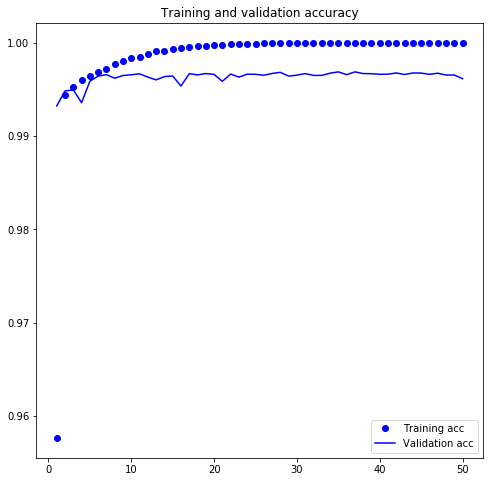

In [24]:
acc = history.history['crf_viterbi_accuracy']
val_acc = history.history['val_crf_viterbi_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize = (8, 8))
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

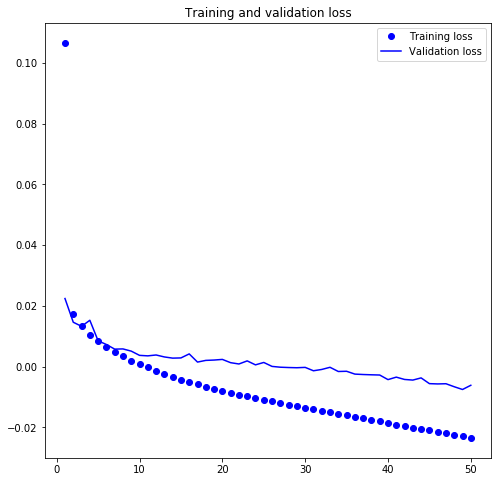

In [25]:
plt.figure(figsize = (8, 8))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [26]:
tsvfile=open("BC5DR-disease-IOB/test.tsv",encoding="utf-8")
tsvreader = csv.reader(tsvfile, delimiter="\t")
data1=[]
sentences1=[]
words1=[]
tags1=[]
for line in tsvreader:
    if line!=[]:
        data1.append(line)
        if line[0] not in words1:
            words1.append(line[0])
        if line[1] not in tags1:
            tags1.append(line[1])
    else:
        sentences1.append(data1)
        data1=[]

X1 = [[word_to_index[w[0] if w[0] in words else "UNK"] for w in s] for s in sentences1]
print(X1[0],X1[1])
count=0
for s in sentences1:
    print(s)
    count=count+1
    if count>5:
        break
# Padding each sequence to have same length  of each word
X1 = pad_sequences(maxlen = max_len, sequences = X1, padding = "post", value = word_to_index["PAD"])
y1 = [[tag_to_index[w[1]] for w in s] for s in sentences1]
print(y1[0])
# padding
y1 = pad_sequences(maxlen = max_len, sequences = y1, padding = "post", value = tag_to_index["PAD"])
num_tag = 3
print(num_tag)
# One hot encoded labels
y1=[to_categorical(i, num_classes = num_tag + 1) for i in y1]
for i in range(len(y1)):
    if y1[i][0][3]==1:
        print(i)
        print(sentences1[i][0])

[1, 2393, 2394, 1163, 524, 304, 978, 268, 1995, 5606, 309, 7, 13, 609, 39, 4022, 2576, 49, 2040, 1140, 78, 22] [24, 1757, 1758, 17, 466, 19, 13, 4565, 3, 637, 3, 785, 1883, 39, 1820, 57, 475, 1140, 78, 1478, 42, 4022, 2576, 49, 991, 19, 184, 1163, 2885, 545, 1627, 2397, 7342, 49, 1, 2393, 2394, 1163, 524, 304, 117, 3535, 19, 1995, 978, 268, 30, 589, 22, 688, 1, 247, 248, 47, 1297, 32, 5606, 22]
[['Torsade', 'B-Disease'], ['de', 'I-Disease'], ['pointes', 'I-Disease'], ['ventricular', 'B-Disease'], ['tachycardia', 'I-Disease'], ['during', 'O'], ['low', 'O'], ['dose', 'O'], ['intermittent', 'O'], ['dobutamine', 'O'], ['treatment', 'O'], ['in', 'O'], ['a', 'O'], ['patient', 'O'], ['with', 'O'], ['dilated', 'B-Disease'], ['cardiomyopathy', 'I-Disease'], ['and', 'O'], ['congestive', 'B-Disease'], ['heart', 'I-Disease'], ['failure', 'I-Disease'], ['.', 'O']]
[['The', 'O'], ['authors', 'O'], ['describe', 'O'], ['the', 'O'], ['case', 'O'], ['of', 'O'], ['a', 'O'], ['56', 'O'], ['-', 'O'], ['yea

In [27]:
y_pred = model.predict(X1)
y_pred = np.argmax(y_pred, axis=-1)
y_test_true = np.argmax(y1, -1)

In [28]:
y_pred = [[idx2tag[i] for i in row] for row in y_pred]
y_test_true = [[idx2tag[i] for i in row] for row in y_test_true] 

In [29]:
print("F1-score is : {:.1%}".format(f1_score(y_test_true, y_pred)))

F1-score is : 86.6%


In [30]:
report = flat_classification_report(y_pred=y_pred, y_true=y_test_true)
print(report)

              precision    recall  f1-score   support

   B-Disease       0.80      0.68      0.74      4424
   I-Disease       0.70      0.72      0.71      2737
           O       0.99      0.99      0.99    117589
         PAD       1.00      1.00      1.00    685943

    accuracy                           1.00    810693
   macro avg       0.87      0.85      0.86    810693
weighted avg       1.00      1.00      1.00    810693



In [31]:
print(y_test_true[0])

['B-Disease', 'I-Disease', 'I-Disease', 'B-Disease', 'I-Disease', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Disease', 'I-Disease', 'O', 'B-Disease', 'I-Disease', 'I-Disease', 'O', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD

In [32]:
print(y_pred[0])

['O', 'O', 'B-Disease', 'I-Disease', 'I-Disease', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Disease', 'I-Disease', 'O', 'B-Disease', 'I-Disease', 'I-Disease', 'O', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD',

In [33]:
y_pred[0][1:16]==y_test_true[0][1:16]

False

In [34]:
##Exact Match
TP=0
TN=0
FP=0
FN=0
i=0
nument=0
while i<len(y_test_true):
    j=0
    #print(i)
    while j <len(y_test_true[i]):
        #print('j ',j)
        if y_test_true[i][j]=='B-Disease':
            st=j
            nument=nument+1
            j=j+1
            while (y_test_true[i][j]=='I-Disease') and j<len(y_test_true[i]):
                j=j+1
                #print('inside ',j)
            end=j
            if y_test_true[i][st:end]==y_pred[i][st:end]:
                TP=TP+1
            else:
                FN=FN+1
        elif y_test_true[i][j]=='O' and y_pred[i][j]=='O':
            TN=TN+1
            j=j+1
            
        elif y_test_true[i][j]=='O' and y_pred[i][j]!='O':
            FP=FP+1
            j=j+1
            
        elif y_test_true[i][j]=='PAD':
            j=j+1

    i=i+1

Precision=TP/(TP+FP)
print(Precision)
Recall=TP/(TP+FN)
print(Recall)
F1=(2*Precision*Recall)/(Precision+Recall)
print(F1)
mat=[[TP,FP],[FN,TN]]
print(mat)

0.721953578336557
0.6749547920433996
0.6976635514018691
[[2986, 1150], [1438, 116439]]


In [35]:
##Partial Match
TP=0
TN=0
FP=0
FN=0
i=0
nument=0
while i<len(y_test_true):
    j=0
    #print(i)
    while j <len(y_test_true[i]):
        #print('j ',j)
        if y_test_true[i][j]=='B-Disease':
            st=j
            nument=nument+1
            j=j+1
            while (y_test_true[i][j]=='I-Disease') and j<len(y_test_true[i]):
                j=j+1
                #print('inside ',j)
            end=j
            found=0
            for k in range(st,end):
                if y_test_true[i][k]==y_pred[i][k]:
                    found=1
                    break
            if found==1:
                TP=TP+1
            else:
                FN=FN+1
            '''if y_test_true[i][st:end]==y_pred[i][st:end]:
                TP=TP+1'''
            
        elif y_test_true[i][j]=='O' and y_pred[i][j]=='O':
            TN=TN+1
            j=j+1
            
        elif y_test_true[i][j]=='O' and y_pred[i][j]!='O':
            FP=FP+1
            j=j+1
            
        elif y_test_true[i][j]=='PAD':
            j=j+1
        
        
    i=i+1
    
Precision=TP/(TP+FP)
print(Precision)
Recall=TP/(TP+FN)
print(Recall)
F1=(2*Precision*Recall)/(Precision+Recall)
print(F1)
mat=[[TP,FP],[FN,TN]]
print(mat)

0.7357536764705882
0.7237793851717902
0.7297174111212397
[[3202, 1150], [1222, 116439]]


In [36]:
len(y_test_true)

4797